# Bag of Words

## Embedding the text

### Read the data

<font color='purple' size=4>Let's start by reading in the script of Deep Space Nine.

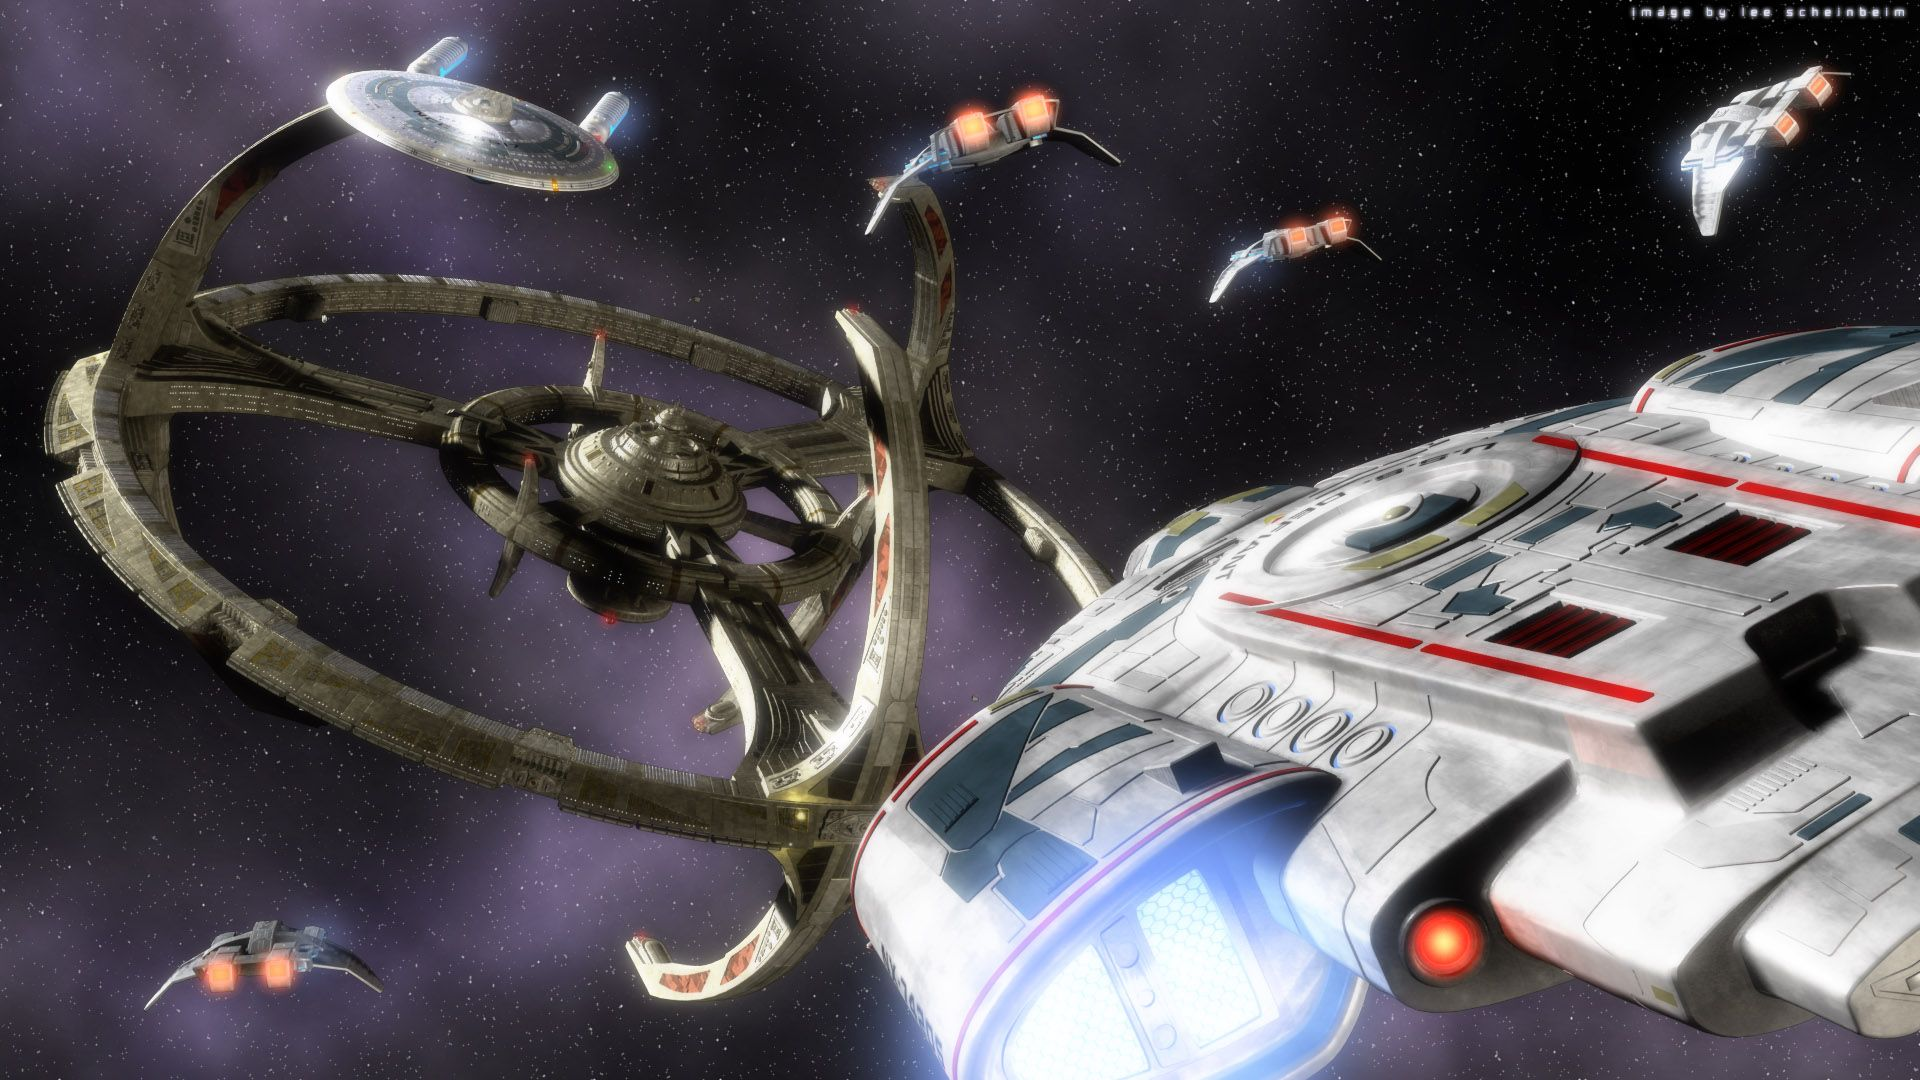

In [1]:
from IPython.display import Image
Image(filename='images/ds9.jpg') 

<font color='purple' size=4>We downloaded 174 scripts from this online source: https://www.st-minutiae.com/resources/scripts/#deepspacenine

In [2]:
import os
os.chdir('/Users/gretel.depaepe/Documents/Projects/deep_space_9')
PATH = 'resources/ScriptsDS9/'
trn_files = !ls {PATH}
trn_files[:10] # as a test

['402.txt',
 '403.txt',
 '404.txt',
 '405.txt',
 '406.txt',
 '407.txt',
 '408.txt',
 '409.txt',
 '410.txt',
 '411.txt']

In [3]:
len(trn_files)

174

In [4]:
import re
scripts = []
counter_issues = 1
for f in trn_files:
    script = {}
    if f != 'all_scripts.json':
        try:
            text = open(PATH+f, 'r').read()
            text = re.sub("\t",' ',text)
            text = re.sub("\n",' ',text)
            text = re.sub(' +',' ',text)
            title = text.split("#")[0].split('"')[1]
            script['title'] = title
            script['text'] = text
            scripts.append(script)
            print("OK", title)
        except:
            print(f, 'Error')
            counter_issues += 1
print(counter, 'files not read')

OK Emissary
OK A Man Alone
OK Past Prologue
OK Babel
OK Captive Pursuit
OK Q-Less
OK Dax
OK The Passenger
OK Move Along Home
OK The Nagus
OK Vortex
OK Battle Lines
414.txt Error
OK Progress
OK If Wishes Were Horses
OK The Forsaken
OK Dramatis Personae
OK Duet
420.txt Error
OK The Homecoming
OK The Circle
OK The Siege
OK Invasive Procedures
OK Cardassians
OK Melora
OK Rules of Acquisition
OK Necessary Evil
OK Second Sight
OK Sanctuary
OK Rivals
OK The Alternate
OK Armageddon Game
OK Whispers
OK Paradise
OK Shadowplay
OK Playing God
OK Profit and Loss
OK Blood Oath
OK The Maquis, Part I
OK The Maquis, Part II
OK The Wire
OK Crossover
OK The Collaborator
OK Tribunal
OK The Jem'Hadar
OK The Search
OK The Search, Part II
OK The House of Quark
OK Equilibrium
OK Second Skin
OK The Abandoned
OK Civil Defense
OK Meridian
OK Defiant
OK Fascination
OK Past Tense, Part I
OK Past Tense, Part II
459.txt Error
OK Heart of Stone
OK Destiny
OK Prophet Motive
OK Visionary
464.txt Error
OK Improbable Cau

NameError: name 'counter' is not defined

<font color='purple' size=4>A few failed to read due to some encoding issues.  We could of course try to solved this, but since we still have 166 scripts left and we want to focus on turning this text into features, we ignore the ones that did not load in this straighforward manner.

In [5]:
len(trn_files) - counter_issues

166

<font color='purple' size=4>Here is our data in a nice pandas DataFrame.  💜 Wes McKinney!

In [6]:
import pandas as pd
df = pd.DataFrame(scripts)
df

,title,text
0,Emissary,"STAR TREK: DEEP SPACE NINE ""Emissary"" #40511-..."
1,A Man Alone,"STAR TREK: DEEP-SPACE NINE ""A Man Alone"" #405..."
2,Past Prologue,"STAR TREK: DEEP SPACE NINE ""Past Prologue"" #4..."
3,Babel,"   STAR TREK: DEEP SPACE NINE ""Babel"" #40511-4..."
4,Captive Pursuit,"STAR TREK: DEEP SPACE NINE ""Captive Pursuit"" ..."
...,...,...
161,When it Rains...,"STAR TREK: DEEP SPACE NINE ""When it Rains... ..."
162,Tacking into the Wind,"STAR TREK: DEEP SPACE NINE ""Tacking into the ..."
163,Extreme Measures,"STAR TREK: DEEP SPACE NINE ""Extreme Measures""..."
164,The Dogs of War,"STAR TREK: DEEP SPACE NINE ""The Dogs of War"" ..."


In [7]:
len(df)

166

### Some options to choose from

<font color='purple' size=4>In order to create Bag of Words embeddings for our scripts we have a couple of options. 

In [8]:
corpus = ['Sisko is talking to Kira',
          'The Commander is talking to the Major',
          'Sisko is talking over the intercom']

<font color='purple' size=4>We can either go for a simple CountVectorizer - we are using Scikit Learn here - which counts how often each word in our vocab appears in each document.  Each word has equal weight.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus)
pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out(), index=['doc1', 'doc2', 'doc3'])

,commander,intercom,kira,major,sisko,talking
doc1,0,0,1,0,1,1
doc2,1,0,0,1,0,1
doc3,0,1,0,0,1,1


<font color='purple' size=4>Or… we can opt for a TFIDF vectorizer.  TDIDF stands for Term Frequency, Inverse Document Frequency and as the name suggests not all words are equally weighed.  Words which are frequent in a document, but rather rare in the entire corpus are weighed more heavily.  The nice things is also that the resulting embedding is already normalized.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus)
pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out(), index=['doc1', 'doc2', 'doc3'])

,commander,intercom,kira,major,sisko,talking
doc1,0.000000,0.000000,0.720333,0.000000,0.547832,0.425441
doc2,0.652491,0.000000,0.000000,0.652491,0.000000,0.385372
doc3,0.000000,0.720333,0.000000,0.000000,0.547832,0.425441


<font color='purple' size=4>One big limitation with most Bag of Word techniques is that when we get an entirely new sentence, it is possible that if contains words we have previously not seen. This is called the Out of Vocabulary problem. Due to time constraints we will not be able to go into details, but do want to mention that FastText offers a solution to this problem since the tokenization is not done based on full words, but rather n-grams.

In [11]:
vectorizer.transform(["Two to beam up"]).toarray()

array([[0., 0., 0., 0., 0., 0.]])

### Represent each DS9 script as a BOW using TFIDF

<font color='purple' size=4>Now let's apply this on our DS9 scripts.  We will focus on TFIDF.

In [12]:
corpus = df['text']
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()

array(['00', '0015', '01', ..., 'zydrolian', 'zygomatic', 'zyree'],
      dtype=object)

<font color='purple' size=4>Let's have a look what our embedded data looks like. Our embedding is a sparse matrix.

In [13]:
X

<166x27239 sparse matrix of type '<class 'numpy.float64'>'
	with 283914 stored elements in Compressed Sparse Row format>

<font color='purple' size=4>So when we expand this to an array we do indeed see a lot of zeros.

In [27]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<font color='purple' size=4>When we zoom in on a slice of the array we do see that some values are not zero where the doc in questions would contain a specific word.

In [15]:
X.toarray()[0:10, 1:10]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00389557, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.02608637, 0.        , 0.        , 0.03217493,
        0.        , 0.00511912, 0.        , 0.        ],


<font color='purple' size=4>The shape of the embedding is 166 - that is the number of scripts or documents, by a little over 27k, which is the size of our vocab.  

In [16]:
X.toarray().shape

(166, 27239)

In [17]:
vectorizer.get_feature_names_out().shape

(27239,)

<font color='purple' size=4>Let’s check if the word ‘raktajino’ is in the vocab.  Yes it is.

In [29]:
# https://www.menti.com/alr5wfihyrv4
'raktajino' in vectorizer.get_feature_names_out()

True

<font color='purple' size=4>For those who are not into Star Trek, here is a video to explain what is raktajino.

In [5]:
from IPython.display import HTML
# https://www.youtube.com/watch?v=nCs_CRx1Ovc
HTML("""
    <video width="800" controls>
        <source src='images/raktajino.mp4' type="video/mp4">
    </video>
""")

## Finding similar documents

<font color='purple' size=4>Let's now see if our Bag of Words solution is helpful in finding similarities. Since our TFIDF embeddings are already normalized, a simple dot product can be used to calculate the cosine similarity. 

In [20]:
pairwise_similarity = X * X.T

<font color='purple' size=4>Note that on the diagonal we always get 1 since a script is of course always most similar to itself. 

In [21]:
pairwise_similarity.toarray()

array([[1.        , 0.43932143, 0.24508473, ..., 0.1531024 , 0.1987502 ,
        0.28426789],
       [0.43932143, 1.        , 0.21189081, ..., 0.1893138 , 0.26422028,
        0.26166971],
       [0.24508473, 0.21189081, 1.        , ..., 0.14098067, 0.12820388,
        0.16169224],
       ...,
       [0.1531024 , 0.1893138 , 0.14098067, ..., 1.        , 0.22461594,
        0.26330834],
       [0.1987502 , 0.26422028, 0.12820388, ..., 0.22461594, 1.        ,
        0.55868347],
       [0.28426789, 0.26166971, 0.16169224, ..., 0.26330834, 0.55868347,
        1.        ]])

In [22]:
pairwise_similarity.shape

(166, 166)

In [23]:
df['title']

0                   Emissary
1                A Man Alone
2              Past Prologue
3                      Babel
4            Captive Pursuit
               ...          
161        When it Rains... 
162    Tacking into the Wind
163         Extreme Measures
164          The Dogs of War
165    What You Leave Behind
Name: title, Length: 166, dtype: object

<font color='purple' size=4>Let’s turn this similarity matrix into a nice pandas DataFrame so we can display the titles of the episodes.  

In [24]:
pairwise_similarity_df = pd.DataFrame(data=pairwise_similarity.toarray(), columns=df['title'], index=df['title'])
pairwise_similarity_df

title,Emissary,A Man Alone,Past Prologue,Babel,Captive Pursuit,Q-Less,Dax,The Passenger,Move Along Home,The Nagus,...,Badda-bing Badda-bang,Penumbra,'Til Death Do Us Part,Strange Bedfellows,The Changing Face of Evil,When it Rains...,Tacking into the Wind,Extreme Measures,The Dogs of War,What You Leave Behind
title,,,,,,,,,,,,,,,,,,,,,
Emissary,1.000000,0.439321,0.245085,0.379296,0.204138,0.239050,0.281745,0.242041,0.250551,0.175712,...,0.108116,0.202548,0.200379,0.181818,0.206927,0.198890,0.159632,0.153102,0.198750,0.284268
A Man Alone,0.439321,1.000000,0.211891,0.356046,0.171393,0.210865,0.287293,0.258928,0.258883,0.207346,...,0.112400,0.158588,0.145595,0.135258,0.165591,0.212829,0.162087,0.189314,0.264220,0.261670
Past Prologue,0.245085,0.211891,1.000000,0.198302,0.097241,0.116104,0.140795,0.130034,0.117694,0.066213,...,0.058408,0.085233,0.079532,0.077824,0.090516,0.139309,0.139761,0.140981,0.128204,0.161692
Babel,0.379296,0.356046,0.198302,1.000000,0.163337,0.196190,0.227102,0.213036,0.211602,0.163536,...,0.096019,0.137013,0.125935,0.117329,0.142006,0.187153,0.139088,0.157944,0.174534,0.209334
Captive Pursuit,0.204138,0.171393,0.097241,0.163337,1.000000,0.102829,0.101110,0.093156,0.091763,0.069352,...,0.048407,0.063808,0.059346,0.062218,0.075629,0.085691,0.063860,0.097892,0.076913,0.097600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
When it Rains...,0.198890,0.212829,0.139309,0.187153,0.085691,0.097927,0.113480,0.137769,0.106623,0.087003,...,0.129498,0.284558,0.420915,0.450275,0.516887,1.000000,0.551977,0.234249,0.337395,0.468068
Tacking into the Wind,0.159632,0.162087,0.139761,0.139088,0.063860,0.075052,0.085431,0.090839,0.082382,0.069039,...,0.104339,0.307659,0.290498,0.378018,0.346812,0.551977,1.000000,0.163583,0.354339,0.442262
Extreme Measures,0.153102,0.189314,0.140981,0.157944,0.097892,0.096904,0.090102,0.117587,0.087257,0.074237,...,0.111632,0.143027,0.129082,0.154931,0.166021,0.234249,0.163583,1.000000,0.224616,0.263308


<font color='purple' size=4>In order to make it readable, this heat map displays the first 50 episodes of DS9.  Note that there are 3 episodes showing a higher similarity: The Homecoming, The Circle and The Siege.

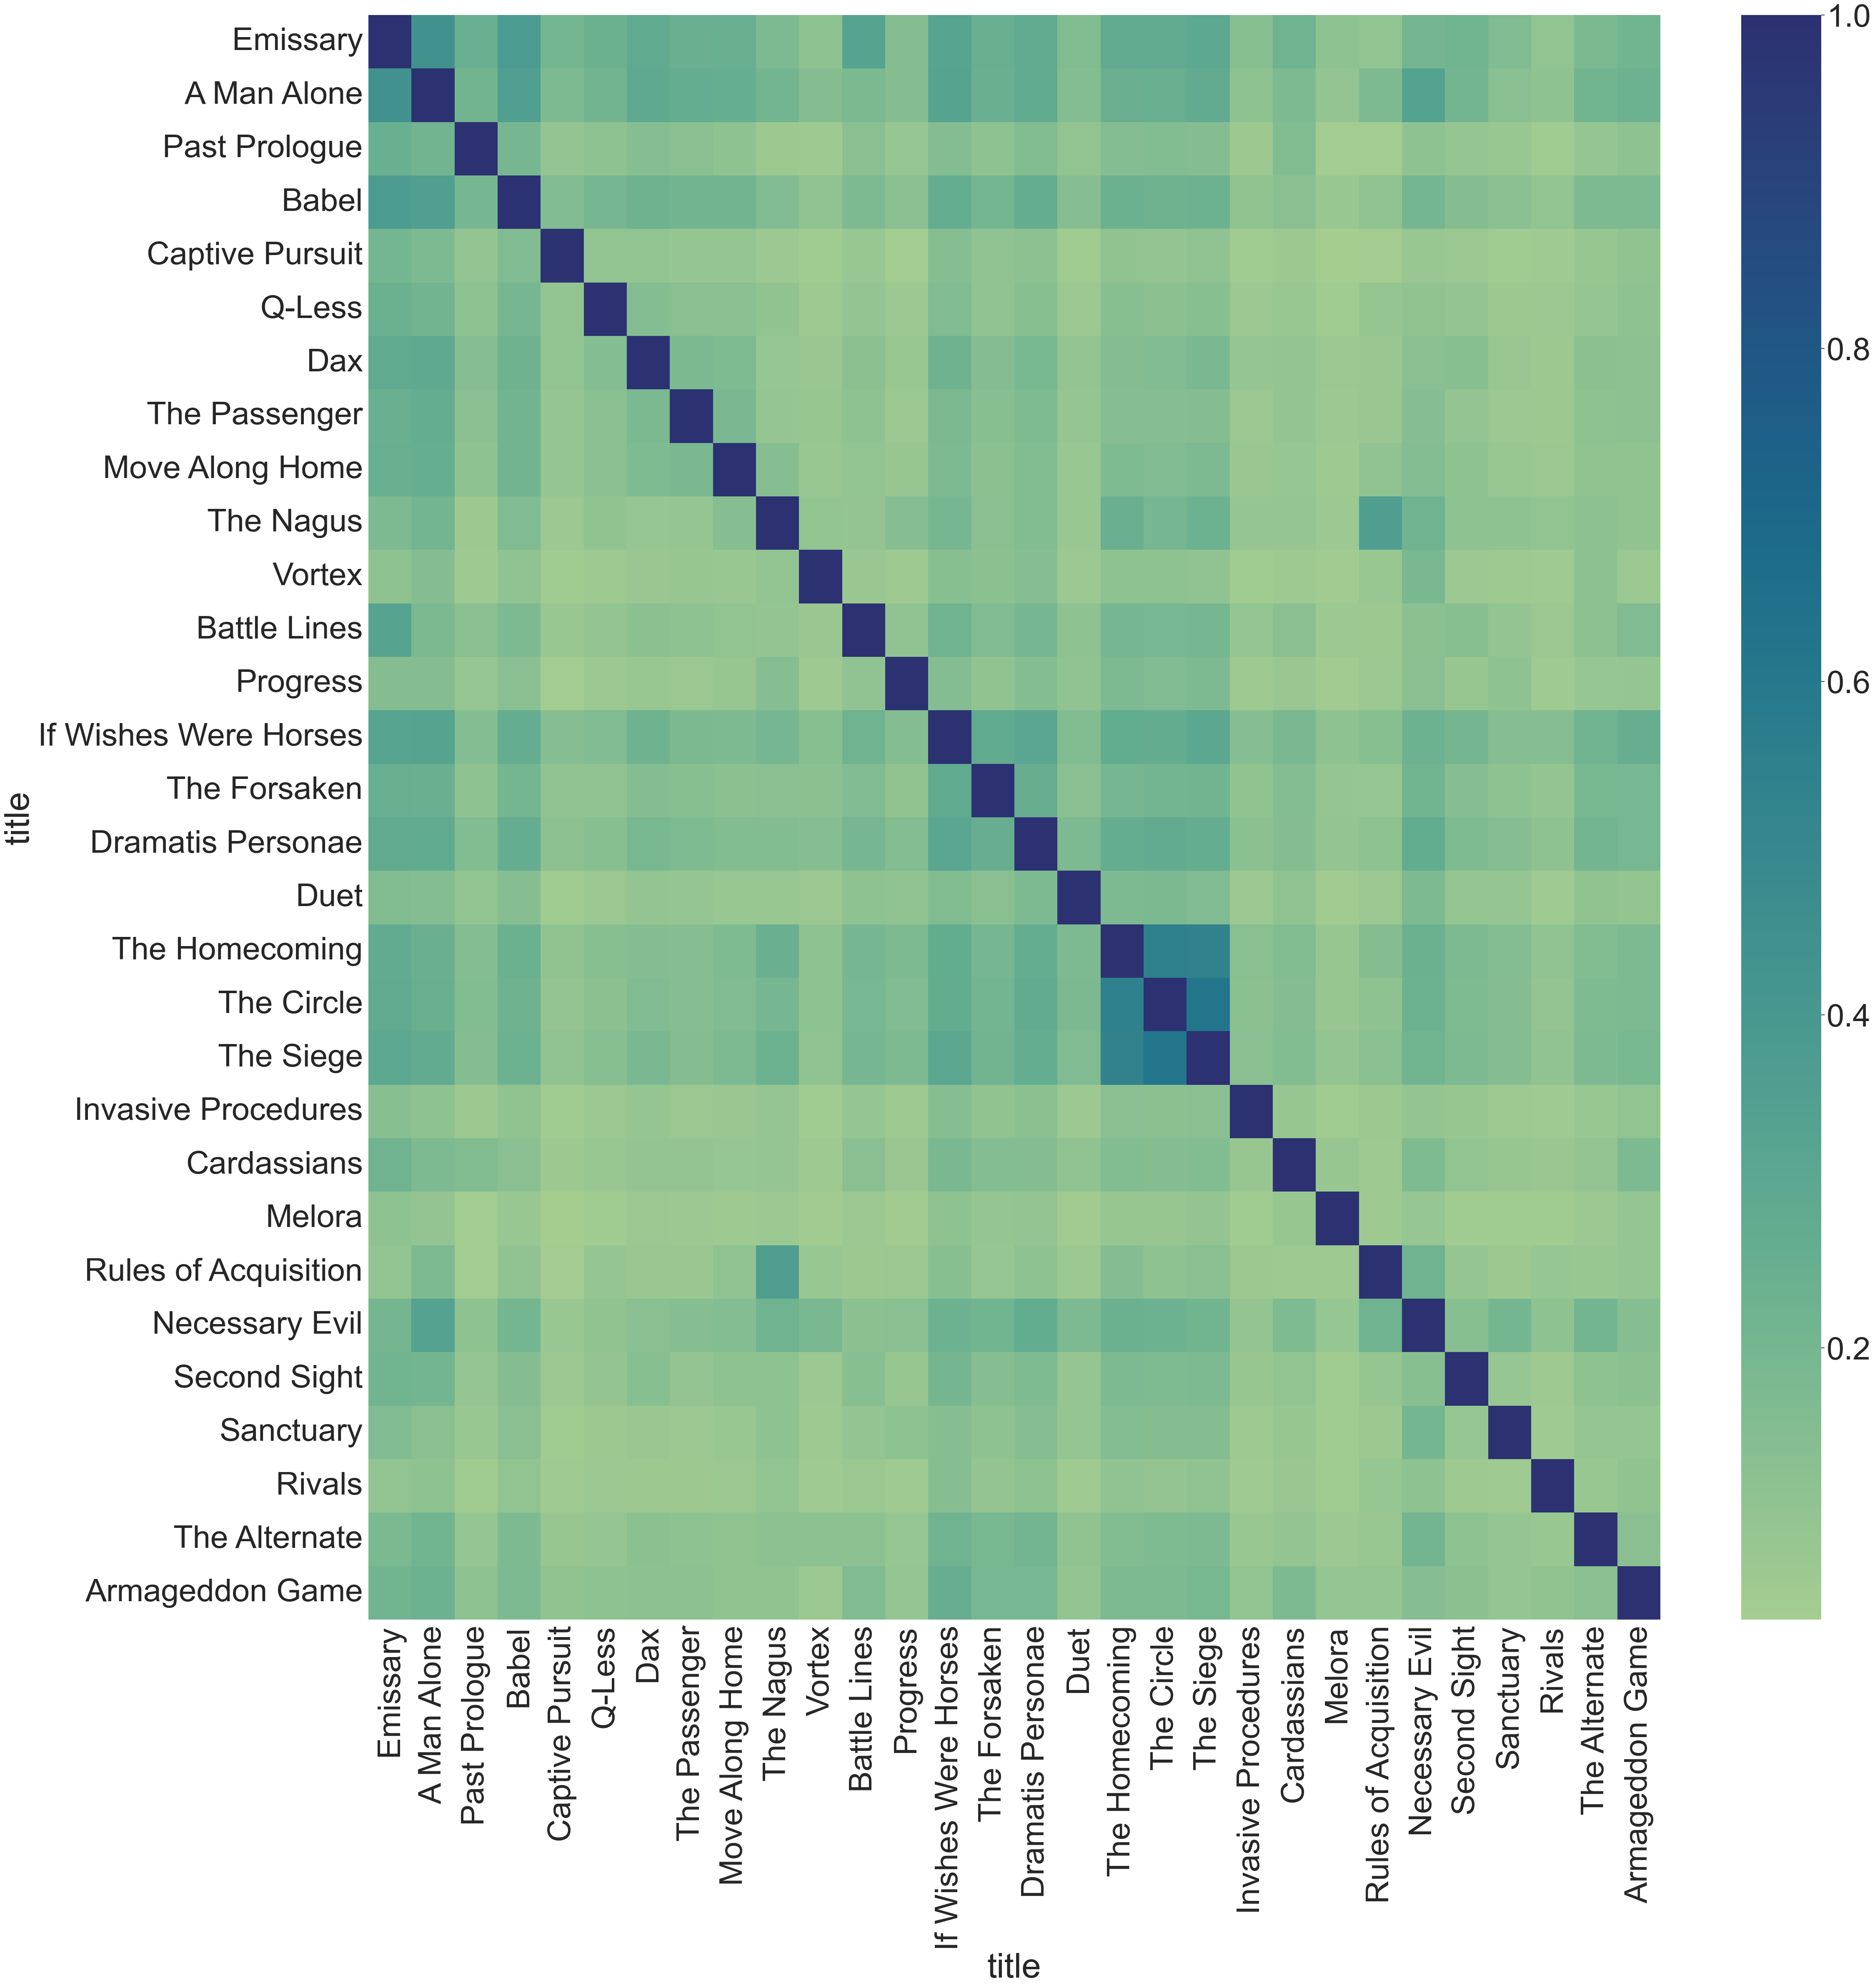

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(50,50)})
sns.set(font_scale=5)
sns.color_palette("tab10")
ax = sns.heatmap(pairwise_similarity_df[list(pairwise_similarity_df.columns)[0:30]][0:30],
                cmap='crest')

<font color='purple' size=4>When checking wikipedia we can see that these 3 episode are part of a longer 3-part story. 
    
source: https://en.wikipedia.org/wiki/List_of_Star_Trek:_Deep_Space_Nine_episodes

<font color='purple' size=4>The graph shows a few other episodes with higher similarity: for example The Nagus and The Rules of Acquisition.  Deep Space 9 fans will understand, but for the everyone else: the nagus is the leader of the Ferengi who’s whole life is centered around making profit and the book with The Rules of Acquisition dictates how they can be as greedy as possible.

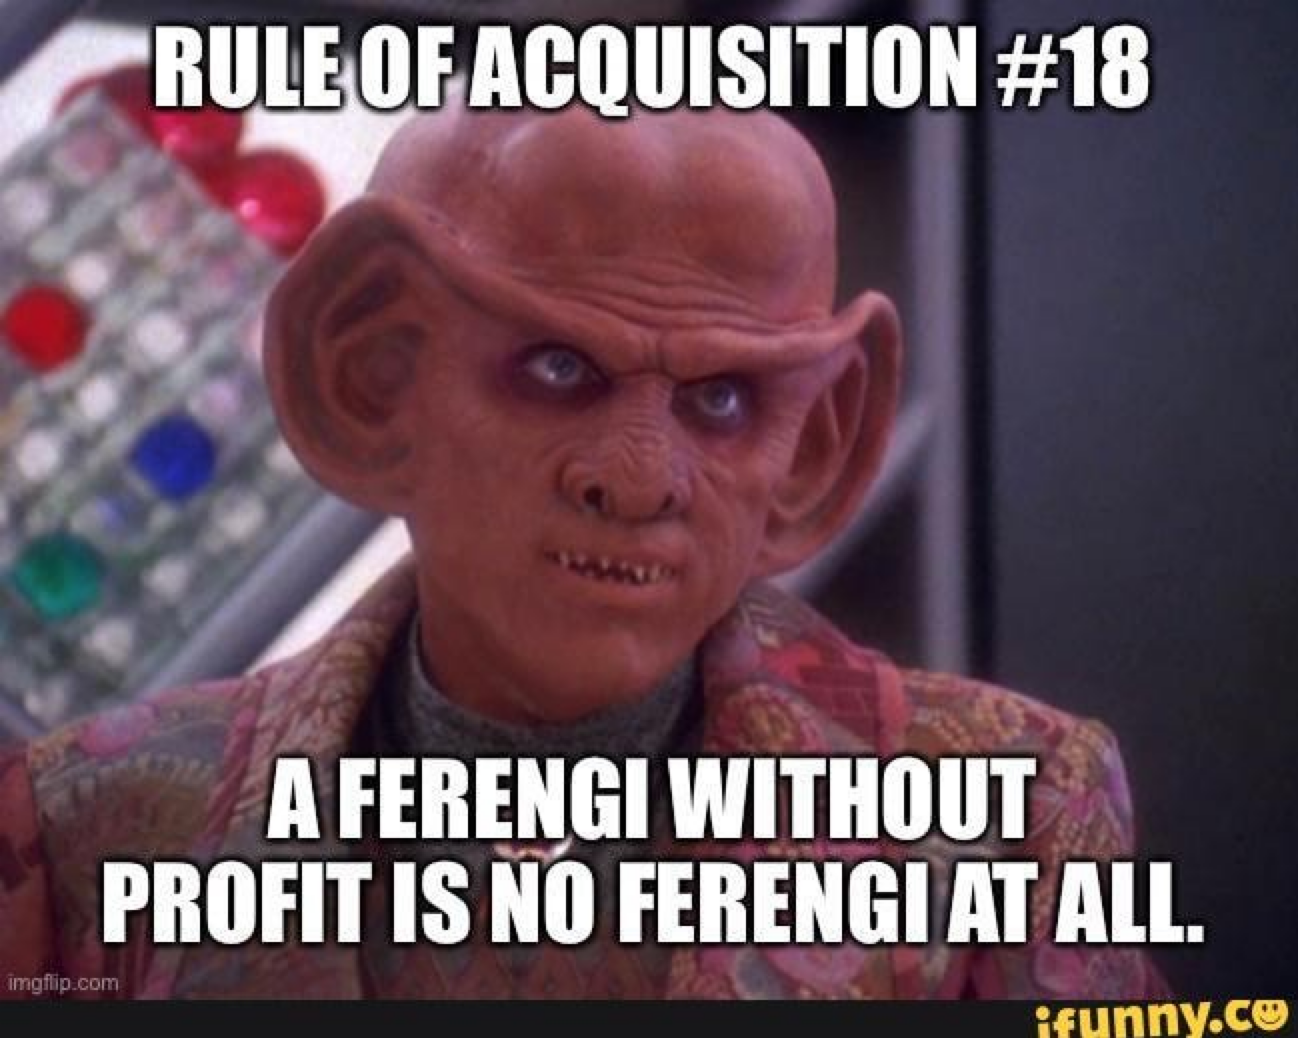

In [1]:
from IPython.display import Image
Image(filename='images/ferengi.png') 